In [1]:
# Performing classification on the MNIST dataset
# MNIST dataset - 70000 small images of handwritten digits with corresponding label
# Can be downloaded straight through Scikit-Learn:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# DESCR key - describes the dataset
# data key - array with one row per instance and one column per feature
# target key - array containing the labels

X, y = mnist["data"], mnist["target"]
print("Size X: ", X.shape, " , Size Y: ", y.shape)

Size X:  (70000, 784)  , Size Y:  (70000,)


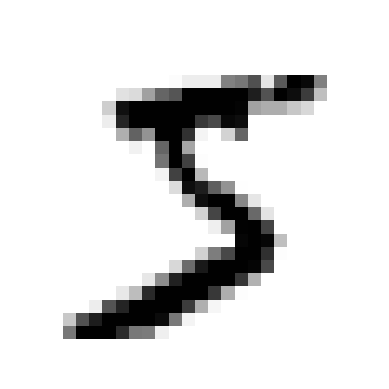

Label:  5


In [3]:
# -> 70000 images and each image has 784 features (image = 28x28 pixels) - each features represents one pixel's intensity (0 - 255)
# let's display one image:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("Label: ",  y[0])

In [4]:
import numpy as np
# Currently - label is a string
print(type(y[0]))
# convert it to integers
y = y.astype(np.uint8)

<class 'str'>


In [5]:
# Creating a train (first 60000) and test (last 10000) sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Training set is already shuffeled - guarantees all cross-validation folds will be similar (i.e. you dont want one fold to be missing some digits)
# Additionally, some algorithms are sensitive to order of the training instances - perform poorly when many similar instances in a row
# However, shuffling can also be a bad idea - especially for time series data, e.g. stock market prices / weather

In [6]:
# Training a Binary Classifier
# Simplified problem - identifiyng one digit, i.e. 5 -> "5-Detector": 5 or not 5
# Target vectors:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
# Options:
# Stochastic Gradient Descent (SGD) - can handle very large datasets efficiently, deals with training instances independently (one at the time)
from sklearn.linear_model import SGDClassifier
# random_state parameter - ensure that the "randomness" is always the same for the stochastic classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
# test
sgd_clf.predict([some_digit])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [9]:
# Performance Measures - trickier for classifiers than regressors - many performance measures available
# 1) Using cross-validation: implementing from scratch - when you need more control over the process
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Performed stratified sampling - for folds with representative ratio of each class
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [10]:
# Let's use built in cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# Classifier looks very good - 95% accuracy
# But first lets test a vary dumb classifier that labels all images as "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# Test the accuracy:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [12]:
# 90% accuracy - simply beacuse only about 10% of images are 5s
# Demonstates why accuracy is generally not the preferred performance measure for classifiers when dealing with skewed datasets
# Meaning when some classes are much more frequent than others

# Confusion Matrix - better alternative:
# idea: count the number of times instances of class A are classified as class B - to see how many times the classifier is "confused"
# need a set of predictions - cross_val_predict
from sklearn.model_selection import cross_val_predict

# similar to cross_val_score() - retuns predictions made on each test fold - clean prediction for each instance in the training set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
# each row - actual class, column - predicted class
# example of perfect confusion matrix:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [14]:
# Confusion matrix - a lot of information
# more concise metric - accuracy of positive predictions - PRECISION of the classifier (TP/(TP+FP))
# typically used with another metric since precision can be 100% if we make just one single positive prediction which is correct
# RECALL (aka sensitivity/true positive rate) = TP/(TP+FN)
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_train_5, y_train_pred)) # 3530/(3530+687)
print("Recall: ", recall_score(y_train_5, y_train_pred)) # 3530/(3530+1897)

Precision:  0.8370879772350012
Recall:  0.6511713705958311


In [15]:
# Not so good anymore - when it claims image is a 5 only 84% of the time, it only detect 5 65% of the time
# Both metric can be combined into F1 score - harmonic mean of precision and recall (gives more weight to low values)
# F1 score will be high, ig both recall and precision are high
# F1 = 2/(1/precision + 1/recall) = 2x precision x recall / (precision + recall)
from sklearn.metrics import f1_score

print("F1 score: ", f1_score(y_train_5, y_train_pred))

F1 score:  0.7325171197343847


In [16]:
# Favours classifiers that have similar precision and recall - not always what you want
# Sometimes its better to have a classifier with higher false negatives than false positives, e.g. detecting safe videos for kids
# i.e. having low recall but high precision
# Opposite case: detecting shoplifters on surveillance images - low precision, high recall - security gets some false alerts but almost all shoplifters will be caught
# It's hard to have it both ways - increasing precision reduces recall, and vice vers - precision/recall tradeoff

In [17]:
# SGDClassifier - computes score based on a decision function, and if the score is higher than a threshold it assigns the instance to positive class
# Scikit-Learn does not let you set the threshold directly but you can have a look at decision scores
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [18]:
# If you use 0 as threshold - predicts true
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# If you use 8000 as threshold - predicts false
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)


[ True]
[False]


In [19]:
# So by raising the threshold, we decreased recall
# How to decide which threshold to use?
# first use cross_val_predict() - getting decision scores not predicitions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                method="decision_function")
# Now can compute precision and recall scores for all possible thresholds - precision_recall_curve() function
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

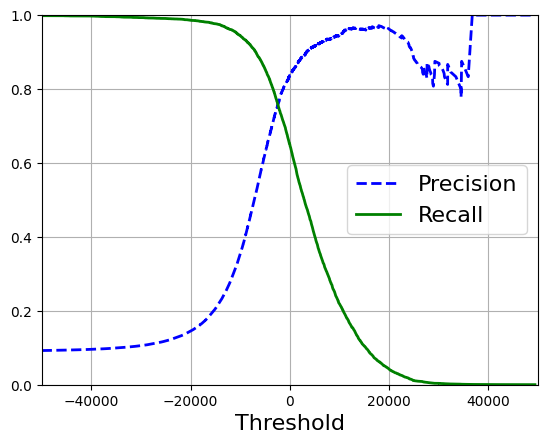

In [20]:
# plot
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

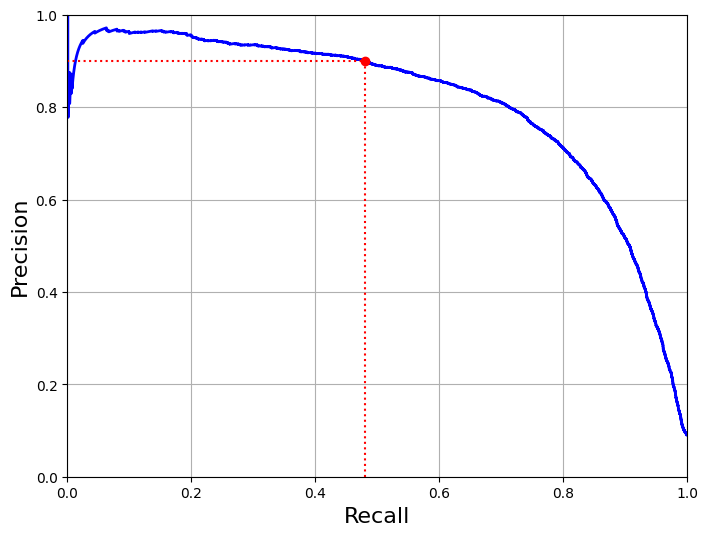

In [21]:
# Can also plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

# Finding the threshold value which will give you precision more than 90%
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [22]:
# To make prediciton with the desired precision score (90 %)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_90)) # 3530/(3530+687)
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


In [23]:
# Straight forward to create a classifier with any precision you want.
# But high-precision classifier is not very useful if its recall is too low

In [24]:
# ROC Curve - receiver operating characteristic - common tool for binary classifiers
# plots true positive rate (recall) against the false positive rate 
# FPR - ratio of negative instances that are incorrectly classified as positive (=1-TNR)
# TNR - called specificity
# ROC - recall vs 1-specificity

# need TPR and FPR for various trehsholds using roc_curve()
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

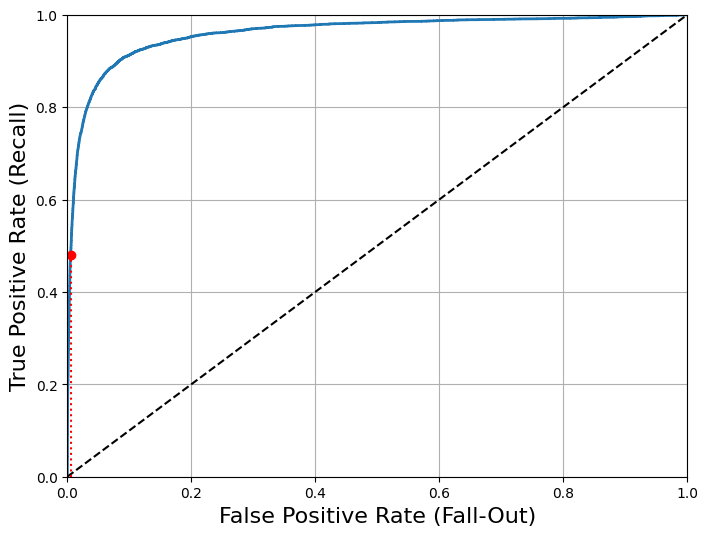

In [25]:
# Plotting ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                  # Not shown
plt.show()

In [26]:
# Once again tradeoffL higher recall(TPR) - more false positives (FPR) the classifier produces
# dotted line - ROC curve of a purely random classifier - good classifier stays as far away form that line as possible

# Different classifiers can be compared by measuring the area under the curve (AUC) - perfect classifier ROC AUC = 1
# random classifier ROC AUC - 0.5:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [27]:
# Some guidelines:
# Use PR curve whenever the positive class is rare or when you care more about false positives than false negatives
# use ROC otherwise 
# from example ROC would make you think that classifier is really good, but this is not the case on PR curve - positive class = rare
# PR curve make is clear there is still room for improvement (get closser to top right corner)

In [28]:
# Lets try with randomForestClassifer
# Doesn't have decision_function() method but has predict_proba() - returns array containing array of probabilities that give instance belongs to a class
# E.g. 70% that image presents a 5

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# Convert to scores for ROC - use positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


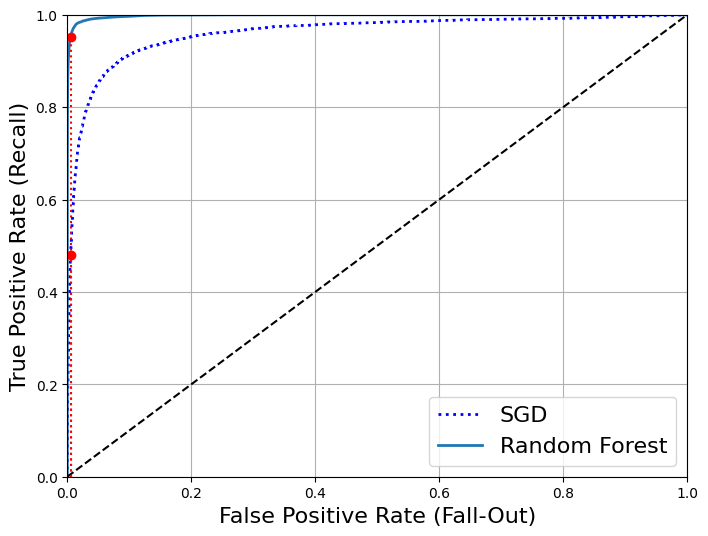

In [29]:
# Plotting 
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [30]:
# Get AUC
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [31]:
# At around 99% precision - 86.6% recall - a lot better

In [37]:
# Multiclass Classification
# Some classifiers are capable of handling multiple classes directly - Random Forest/naive Bayes classifier
# Others are strictly binary classifiers --> One-versus-all strategy - train multiple binary classifiers and then get a decision score from each given an image
# One-versus-one (OvO) strategy - classifier to distinguish 0s and 1s, another for 0 and 2s, ... -> Nx(N-1)/2 classifiers (if N = 10 -> 45 classifiers)
# advantage of OvO - only needs to be trained on the part of the training set for the 2 classes it must distinguish
# beneficial with classifiers that scale poorly with the size of the training set (Support Vector Machine), but mostly OvA is preferred

# Scikit-Learn detects when you try to use a binary classifier for multiclassification tasks and automatically runs OvA (except for SVM)
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [39]:
# Let's see the decision_function() method to see the scores for all values
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print("Classes: ", sgd_clf.classes_)
print("Highest value number: ", np.argmax(some_digit_scores))
sgd_clf.classes_[np.argmax(some_digit_scores)]

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
Classes:  [0 1 2 3 4 5 6 7 8 9]
Highest value number:  3


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


np.uint8(3)

In [41]:
# To force Scikit-Learn to use OvO/OvA strategy - ise OneVsOneClassifier or OneVsRestClassifier class
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print("OvO strategy prediction: ", ovo_clf.predict([some_digit]))
print("Tot. number of classifiers: ",  len(ovo_clf.estimators_))

OvO strategy prediction:  [5]
Tot. number of classifiers:  45


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


In [42]:
# Using a different classifier is just as easy:
forest_clf.fit(X_train, y_train)
print("Rand. Forest pred: ", forest_clf.predict([some_digit]))

Rand. Forest pred:  [5]


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [46]:
# This time OvA or OvO not needed because Random Forest classifiers can directly classify multiple instances into multiple classes
# display probabilites for each digit
forest_clf.predict_proba([some_digit])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [47]:
# model estimates that 5th index in the array has 90% probability of being correct
# To evaluate these classigfier --> cross-validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [48]:
# Does quite good ~86% accuracy - true random classifier would get 10% accuracy, but doing some tuning one can increase the score
# e.g. by simply scaling inputs - accuracy can be increased to abour 89%
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [49]:
# Error Analysis
# In real project: exploring data preparation options. trying multiple models, shorlisting the best ones and fine -tuning their params
# Here we assume we did that already and want to improve our model - need to analyze types of errors it makes
# Confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

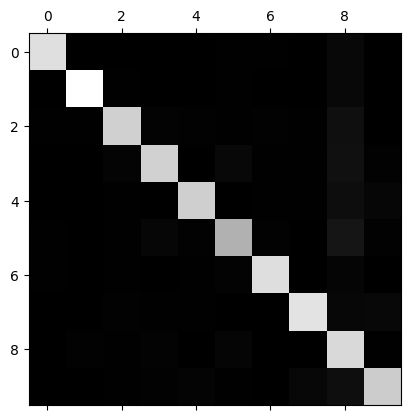

In [50]:
# Can also look at the image representation of the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

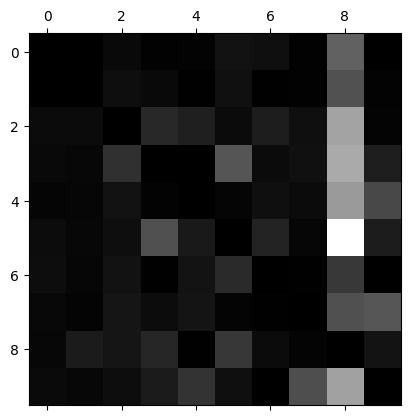

In [51]:
# Confusion matrix looks okay - most things on the diagonal
# 5s look slightly darker - either fewer 5s in the datasets or classifier does not perform that well
# Lets focus the plot on errors - divide each value in the C.M. by number of images in the corresponding class - error rate
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [54]:
# Rows - actual classes
# Columns - predicted classes
# From the image - many images get misclassified as 8s, but row for the class 8 not that badd
# confusion matrix not necessary symmetrical
# 3s and 5s get often confused as well (bith direction)

# Should spend time to reduce the false 8s:
# e.g. get more data for digit that look like 8s (but are not),
# or engineer new features that would help the classifier - e.g. algorithm that can count the numfer of closed loops (8 has 2, 6 has 1, 5 has 0)
# or preprecosess the images - using Scikit-Learn, Pillow or OpenCV to make paterns stand out more
# Analyzing individual errors - more difficult and time consuming

In [57]:
# EXTRA - helper function to plot digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

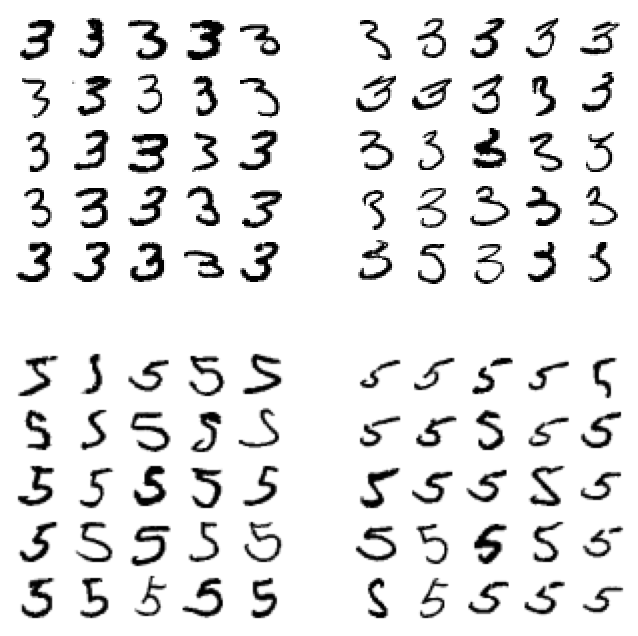

In [60]:
# let's plot examples or 3s and 5s (plot_digits() - uses Matplotlib's imshow() function)
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [61]:
# Left shows digits classified as 3s and right shows digits classifed as a 5
# some of the digits are badly written but most misclassification seem obvious errors to us
# SGDClassifier - linear model: assigns a weight per class to each pixel
# when it sees a new image it just sums up the weighted pixel intensities to get a score of each class
# 3s and 5s differ only by a few pixels - model will easily confuse them
# classifier quite sensitive to image shifting and rotations
# could preporcess the images to ensure that they are well centered and not rotated

In [62]:
# Multilabel classification
# - when you want to output multiple classes for each instance, e.g. face-recognition when multiple people are present
# simple example:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [63]:
# creates y_multilaber array containing two target labels for each digit image
# first - indicates whether the digit is large (7/8/9),
# second - wheter it is odd or not
# using Kneighbors classifier we train using multiple targets array
# Prediction outputs two labels
knn_clf.predict([some_digit])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [64]:
# The digit 5 is indeed not large (False) and odd (True)
# Many ways to evaluate multilabel classifier - right metric depends on the project
# e.g. F1 score for each individual label and then computing the average score:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

In [65]:
# Assumes that all labels are equally important (might not be the case)
# To add more weight to each label set average="weighted"

In [66]:
# Multioutput Classification
# generalization of multilabel classification - each label can be multiclass (more than 2 possible values)
# Example: remove noise from image - each classifier's output is multilabel (one label per pixel) 
# and each label can have multiple values (pixel intensity from 0 to  255)

# add noise with NumPy's randint() function, target will be the original images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

<class 'pandas.core.series.Series'>


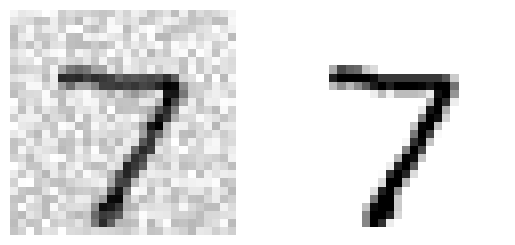

In [81]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
print(type(X_test_mod.iloc[some_index]))

some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
plt.show()

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


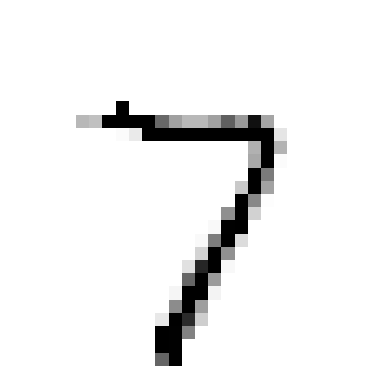

In [82]:
# left is the nouse inpuut and right is the clean target
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)